In [10]:
import sys
sys.path.insert(0, '..')
#for local import of parent dict

## Import the usual libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms

from sklearn.metrics.pairwise import pairwise_distances
import scipy

import os
import numpy as np

#synth Data
from ggml.generator import get_pointcloud, create_t_triplets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Optimal Transport
import ot

#Plotting
from ggml.plot import plot_distribution, plot_emb, hier_clustering, plot_ellipses
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

## print out the pytorch version used (1.31 at the time of this tutorial)
print(torch.__version__)

2.4.0+cu118


In [11]:
## configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

def pairwise_mahalanobis_distance_npy(X_i,X_j=None,w=None,numThreads=32):
    # W has shape dim x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 
    if X_j is None:
        if w is None or isinstance(w,str):
            return pairwise_distances(X_i,metric=w,n_jobs=numThreads) #cdist .. ,X_j)
        else:
            if w.ndim == 2 and w.shape[0]==w.shape[1]:
                return pairwise_distances(X_i,metric="mahalanobis",n_jobs=numThreads,VI =w)    
            else:
                X_j = X_i
    #Transform poins of X_i,X_j according to W
    if w is None or isinstance(w,str):
        return scipy.spatial.distance.cdist(X_i,X_j,metric=w)
    #Assume w is cov matrix of mahalanobis distance
    elif w.ndim == 1:
        #assume cov=0, scale dims by diagonal
        w = np.diag(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)

        #proj_X_i = X_i * w[None,:]
        #proj_X_j = X_j * w[None,:]
    else: 
        w = np.transpose(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)
    
    return np.linalg.norm(proj_X_i[:,np.newaxis,:]  -  proj_X_j[np.newaxis,:,:],axis=-1)  

def plot_w_theta(w_theta=None,M=None,ax=None):
    if M is None:
        if isinstance(w_theta, torch.Tensor):
            W = w_theta.clone().detach().numpy()
        else:
            W = w_theta
        M = np.dot(W,np.transpose(W))
    M = M / np.linalg.norm(M)
    return plot_ellipses(M,ax=ax)

cuda:0


In [12]:
class CustomSyntheticDataset(Dataset):
    #The __init__ function is run once when instantiating the Dataset object.
    def __init__(self, *args, **kwargs):
        #Generate syntehtic data
        distributions, distributions_labels, points, point_labels, distribution_modes = get_pointcloud(*args, **kwargs)

        #Population-level 
        self.distributions = distributions
        self.distributions_labels = distributions_labels
        self.distribution_modes = distribution_modes

        #Unit-level 
        self.datapoints = points 
        self.datapoints_labels = point_labels

        #Triplets
        self.triplets = create_t_triplets(distributions,distributions_labels,**kwargs)

    def __len__(self):
        #Datapoints to train are always given as triplets
        return len(self.triplets)

    def __getitem__(self, idx):
        #Returns elements and labels of triplet at idx
        i,j,k = self.triplets[idx]
        return np.stack((self.distributions[i],self.distributions[j],self.distributions[k]),dtype="f"),np.stack((self.distributions_labels[i],self.distributions_labels[j],self.distributions_labels[k]),dtype="f")
    
    def get_raw_distributions(self):
        return self.distributions,self.distributions_labels
    
    def compute_OT_on_dists(self,ground_metric = None,w = None,legend="Side"):
        D = np.zeros((len(self.distributions),len(self.distributions)))
        for i,distribution_i in enumerate(self.distributions):
            for j,distribution_j in enumerate(self.distributions):
                if i < j:
                    if w is not None:
                        M = pairwise_mahalanobis_distance_npy(distribution_i,distribution_j,w)
                        D[i,j] = ot.emd2([],[],M)
                else:
                    D[i,j]=D[j,i]
        
        hardcoded_symbols = [i % 10 for i in range(len(self.distributions))]
        plot_emb(D,method='umap',colors=self.distributions_labels,symbols=hardcoded_symbols,legend=legend,title="UMAP",verbose=True,cmap=sns.cubehelix_palette(as_cmap=True),annotation=None,s=200)

        hier_clustering(D,self.distributions_labels, ax=None,cmap=sns.cubehelix_palette(as_cmap=False,n_colors=len(np.unique(self.distributions_labels))),dist_name="W_θ")
        return D

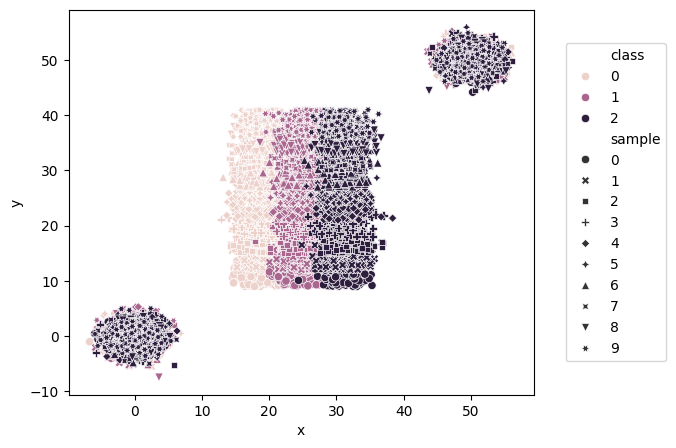

'\nfeat_dim = next(iter(train_dataset))[0].shape[-1]\n\nw = np.ones((feat_dim))\ntraining_data.compute_OT_on_dists(w = w,legend=None)\n\nw = np.zeros((feat_dim))\nw[0] = 1\ntraining_data.compute_OT_on_dists(w = w,legend=None) #euclidean\n'

In [13]:
neighbor_t = [3] #,5,7
rank_k = [5] #,10,25,50,100,200] 

alphas = [0.1,1,10,100,1000] #,10,50,100]
lambdas = [0.1,1,10,100,1000] #,10,50,100]

n = 200
means = [5,10,15]
label =[0,1,2]
offsets = np.arange(0,30,3)+1.5

shared_means_x = [0, 40]
shared_means_y = [0, 50]

training_data = {}
train_dataset = {}

for t in neighbor_t:
        training_data[t] = CustomSyntheticDataset(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,t=t,noise_scale=1,noise_dims=199)
        for a in alphas:
                for l in lambdas:
                        for k in rank_k:


                                #training_data[(a,l,t,k)] = 
                
                                train_dataset[(a,l,t,k)] =  DataLoader(training_data[t] , batch_size=128, shuffle=True) #training_data[(a,l,t,k)]

#test_data = CustomSyntheticDataset(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False)

#test_dataset = DataLoader(test_data, batch_size=64, shuffle=True)

#PLOTTING
'''
feat_dim = next(iter(train_dataset))[0].shape[-1]

w = np.ones((feat_dim))
training_data.compute_OT_on_dists(w = w,legend=None)

w = np.zeros((feat_dim))
w[0] = 1
training_data.compute_OT_on_dists(w = w,legend=None) #euclidean
'''



In [14]:
'''
train_features, train_labels = next(iter(train_dataset))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


trpl_distributions = train_features[0]
trpl_label = train_labels[0]


plot_distribution(trpl_distributions,trpl_label)

plt.show()
print(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")
'''

'\ntrain_features, train_labels = next(iter(train_dataset))\nprint(f"Feature batch shape: {train_features.size()}")\nprint(f"Labels batch shape: {train_labels.size()}")\n\n\ntrpl_distributions = train_features[0]\ntrpl_label = train_labels[0]\n\n\nplot_distribution(trpl_distributions,trpl_label)\n\nplt.show()\nprint(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")\n'

In [15]:
def pairwise_mahalanobis_distance(X_i,X_j,w):
    # W has shape (rank k<=dim) x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 




    #Transform poins of X_i,X_j according to W
    if w.dim() == 1:
        #assume cov=0, scale dims by diagonal
        proj_X_i = X_i * w[None,:]
        proj_X_j = X_j * w[None,:]

    else: 
        w = torch.transpose(w,0,1)
        proj_X_i = torch.matmul(X_i,w)
        proj_X_j = torch.matmul(X_j,w)

    return torch.linalg.norm(proj_X_i[:,torch.newaxis,:]  -  proj_X_j[torch.newaxis,:,:],dim=-1)    

#Small example with the identity as cov matrix and a cov matrix with var 0 for dim 2 (only consider dim 1)
dim = 200 #next(iter(train_dataset))[0].shape[-1] #TODO get dim from dataset object
dia_only = False


'''
w_euc = torch.from_numpy(np.asarray([[1,0],[0,1]],dtype="f"))


w_opt = torch.from_numpy(np.asarray([[1,0],[0,0]],dtype="f"))
w_opt.requires_grad_(requires_grad=True) 


x = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))
y = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))
z = torch.from_numpy(np.asarray([[0,0],[0,1],[0,0],[0,1]],dtype="f"))

print(pairwise_mahalanobis_distance(x,y,w_rand))
print(pairwise_mahalanobis_distance(x,y,w_opt))
'''


'\nw_euc = torch.from_numpy(np.asarray([[1,0],[0,1]],dtype="f"))\n\n\nw_opt = torch.from_numpy(np.asarray([[1,0],[0,0]],dtype="f"))\nw_opt.requires_grad_(requires_grad=True) \n\n\nx = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))\ny = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))\nz = torch.from_numpy(np.asarray([[0,0],[0,1],[0,0],[0,1]],dtype="f"))\n\nprint(pairwise_mahalanobis_distance(x,y,w_rand))\nprint(pairwise_mahalanobis_distance(x,y,w_opt))\n'

In [16]:
from tqdm import tqdm

lr = 0.01


n_threads = 100
iterations= 25 #0
plot_every_i_iterations = 24
save_every_i_iterations = 5

def triplet_loss(triplet,w,alpha=torch.scalar_tensor(0.1)):
    X_i,X_j,X_k = triplet

    D_ij = pairwise_mahalanobis_distance(X_i,X_j,w)
    D_jk = pairwise_mahalanobis_distance(X_j,X_k,w)

    W_ij = ot.emd2([],[],M=D_ij,log=False,numThreads=n_threads)
    W_jk = ot.emd2([],[],M=D_jk,log=False,numThreads=n_threads)


    return torch.nn.functional.relu(W_ij -  W_jk + alpha)


In [17]:
import time

results = {}
thetas = {}
times = {}


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [06:59<00:00, 83.80s/it] 


Iteration 0 with Loss  7873.87744140625
Average time for neigh 3 and Rank 5 is 419.0049238204956


100%|██████████| 5/5 [06:34<00:00, 78.94s/it]


Iteration 1 with Loss  1003.9234008789062
Average time for neigh 3 and Rank 5 is 406.8536754846573


100%|██████████| 5/5 [07:03<00:00, 84.68s/it] 


Iteration 2 with Loss  556.775634765625
Average time for neigh 3 and Rank 5 is 412.37029488881427


100%|██████████| 5/5 [06:24<00:00, 76.92s/it] 


Iteration 3 with Loss  753.7134399414062
Average time for neigh 3 and Rank 5 is 405.43555557727814


100%|██████████| 5/5 [05:53<00:00, 70.63s/it] 


Iteration 4 with Loss  564.1446533203125
Average time for neigh 3 and Rank 5 is 394.9837621212006


100%|██████████| 5/5 [04:43<00:00, 56.72s/it]


Iteration 5 with Loss  502.40362548828125
Average time for neigh 3 and Rank 5 is 376.4186849196752


100%|██████████| 5/5 [04:36<00:00, 55.35s/it]


Iteration 6 with Loss  578.3399047851562
Average time for neigh 3 and Rank 5 is 362.18392545836315


100%|██████████| 5/5 [04:29<00:00, 53.86s/it]


Iteration 7 with Loss  590.4482421875
Average time for neigh 3 and Rank 5 is 350.5767193734646


100%|██████████| 5/5 [04:38<00:00, 55.64s/it]


Iteration 8 with Loss  446.2137145996094
Average time for neigh 3 and Rank 5 is 342.53316518995496


100%|██████████| 5/5 [05:28<00:00, 65.60s/it]


Iteration 9 with Loss  590.6021118164062
Average time for neigh 3 and Rank 5 is 341.0818557024002


100%|██████████| 5/5 [05:16<00:00, 63.37s/it]


Iteration 10 with Loss  442.7770690917969
Average time for neigh 3 and Rank 5 is 338.87767653031784


100%|██████████| 5/5 [04:27<00:00, 53.60s/it]


Iteration 11 with Loss  489.0484313964844
Average time for neigh 3 and Rank 5 is 332.97061822811764


100%|██████████| 5/5 [04:37<00:00, 55.57s/it]


Iteration 12 with Loss  362.85888671875
Average time for neigh 3 and Rank 5 is 328.73257327079773


100%|██████████| 5/5 [05:31<00:00, 66.27s/it]


Iteration 13 with Loss  430.47772216796875
Average time for neigh 3 and Rank 5 is 328.9184650012425


100%|██████████| 5/5 [06:19<00:00, 75.84s/it]


Iteration 14 with Loss  475.9178161621094
Average time for neigh 3 and Rank 5 is 332.26966071128845


100%|██████████| 5/5 [05:46<00:00, 69.30s/it]


Iteration 15 with Loss  531.1010131835938
Average time for neigh 3 and Rank 5 is 333.15883876383305


100%|██████████| 5/5 [05:58<00:00, 71.66s/it]


Iteration 16 with Loss  547.9548950195312
Average time for neigh 3 and Rank 5 is 334.6370548500734


100%|██████████| 5/5 [05:38<00:00, 67.65s/it]


Iteration 17 with Loss  427.19598388671875
Average time for neigh 3 and Rank 5 is 334.83854676617517


100%|██████████| 5/5 [05:24<00:00, 64.82s/it]


Iteration 18 with Loss  446.99993896484375
Average time for neigh 3 and Rank 5 is 334.27374439490467


100%|██████████| 5/5 [05:43<00:00, 68.76s/it]


Iteration 19 with Loss  602.7608642578125
Average time for neigh 3 and Rank 5 is 334.7511550307274


100%|██████████| 5/5 [05:38<00:00, 67.78s/it]


Iteration 20 with Loss  546.1687622070312
Average time for neigh 3 and Rank 5 is 334.9479746250879


100%|██████████| 5/5 [05:38<00:00, 67.64s/it]


Iteration 21 with Loss  393.712890625
Average time for neigh 3 and Rank 5 is 335.0968515222723


100%|██████████| 5/5 [06:09<00:00, 73.96s/it]


Iteration 22 with Loss  507.68902587890625
Average time for neigh 3 and Rank 5 is 336.6050057929495


100%|██████████| 5/5 [06:02<00:00, 72.59s/it]


Iteration 23 with Loss  485.91748046875
Average time for neigh 3 and Rank 5 is 337.70361735423404


100%|██████████| 5/5 [06:19<00:00, 75.81s/it]


Iteration 24 with Loss  659.8133544921875
Average time for neigh 3 and Rank 5 is 339.35742526054383
Compute all OT distances after 24 iterations


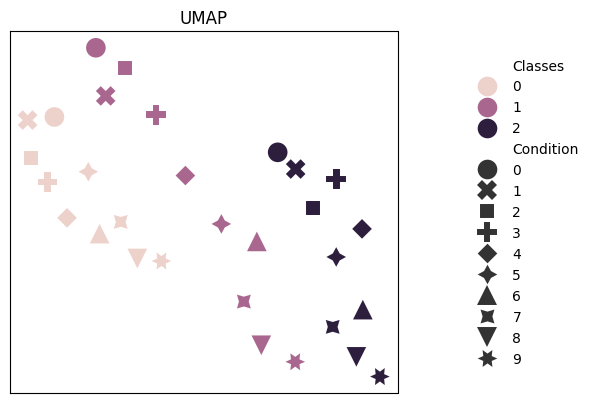

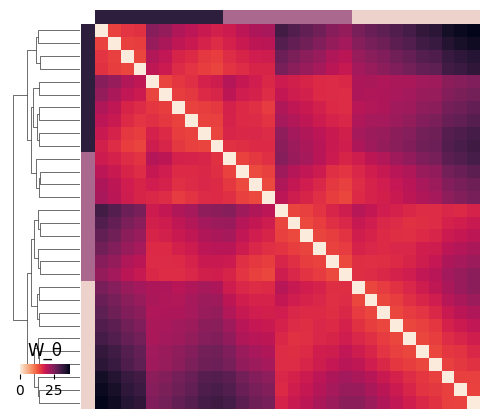

100%|██████████| 5/5 [06:36<00:00, 79.28s/it] 


Iteration 0 with Loss  8486.5625
Average time for neigh 3 and Rank 5 is 396.4264016151428


100%|██████████| 5/5 [05:55<00:00, 71.17s/it]


Iteration 1 with Loss  1208.740966796875
Average time for neigh 3 and Rank 5 is 376.1322865486145


100%|██████████| 5/5 [11:13<00:00, 134.64s/it]


Iteration 2 with Loss  714.066650390625
Average time for neigh 3 and Rank 5 is 475.1603241761525


100%|██████████| 5/5 [06:02<00:00, 72.49s/it]


Iteration 3 with Loss  728.2075805664062
Average time for neigh 3 and Rank 5 is 446.98303562402725


100%|██████████| 5/5 [07:34<00:00, 90.97s/it] 


Iteration 4 with Loss  665.328125
Average time for neigh 3 and Rank 5 is 448.5548484325409


100%|██████████| 5/5 [06:12<00:00, 74.42s/it]


Iteration 5 with Loss  828.3984375
Average time for neigh 3 and Rank 5 is 435.8141925732295


100%|██████████| 5/5 [06:12<00:00, 74.53s/it]


Iteration 6 with Loss  631.6524658203125
Average time for neigh 3 and Rank 5 is 426.7921074117933


100%|██████████| 5/5 [04:35<00:00, 55.16s/it]


Iteration 7 with Loss  606.3960571289062
Average time for neigh 3 and Rank 5 is 407.91600835323334


100%|██████████| 5/5 [06:02<00:00, 72.56s/it]


Iteration 8 with Loss  679.2389526367188
Average time for neigh 3 and Rank 5 is 402.90096767743427


100%|██████████| 5/5 [05:52<00:00, 70.56s/it]


Iteration 9 with Loss  511.3882751464844
Average time for neigh 3 and Rank 5 is 397.89303586483004


100%|██████████| 5/5 [06:07<00:00, 73.59s/it]


Iteration 10 with Loss  512.9635620117188
Average time for neigh 3 and Rank 5 is 395.1712319200689


100%|██████████| 5/5 [06:02<00:00, 72.53s/it]


Iteration 11 with Loss  510.8606872558594
Average time for neigh 3 and Rank 5 is 392.4599259495735


100%|██████████| 5/5 [06:05<00:00, 73.09s/it]


Iteration 12 with Loss  471.28839111328125
Average time for neigh 3 and Rank 5 is 390.38284078011145


100%|██████████| 5/5 [06:52<00:00, 82.42s/it] 


Iteration 13 with Loss  527.2542724609375
Average time for neigh 3 and Rank 5 is 391.93300686563765


100%|██████████| 5/5 [09:35<00:00, 115.07s/it]


Iteration 14 with Loss  462.0479736328125
Average time for neigh 3 and Rank 5 is 404.16060536702474


100%|██████████| 5/5 [12:44<00:00, 152.86s/it]


Iteration 15 with Loss  529.3444213867188
Average time for neigh 3 and Rank 5 is 426.66875925660133


100%|██████████| 5/5 [13:54<00:00, 166.95s/it]


Iteration 16 with Loss  529.1552124023438
Average time for neigh 3 and Rank 5 is 450.67396882001094


100%|██████████| 5/5 [12:53<00:00, 154.69s/it]


Iteration 17 with Loss  680.3130493164062
Average time for neigh 3 and Rank 5 is 468.6054296625985


100%|██████████| 5/5 [13:10<00:00, 158.18s/it]


Iteration 18 with Loss  607.656982421875
Average time for neigh 3 and Rank 5 is 485.56961304263064


100%|██████████| 5/5 [06:57<00:00, 83.56s/it] 


Iteration 19 with Loss  548.354736328125
Average time for neigh 3 and Rank 5 is 482.18096828460693


100%|██████████| 5/5 [05:51<00:00, 70.27s/it]


Iteration 20 with Loss  720.0325927734375
Average time for neigh 3 and Rank 5 is 475.95042817933216


100%|██████████| 5/5 [05:57<00:00, 71.49s/it]


Iteration 21 with Loss  487.1539001464844
Average time for neigh 3 and Rank 5 is 470.5638446374373


100%|██████████| 5/5 [05:57<00:00, 71.54s/it] 


Iteration 22 with Loss  495.7179870605469
Average time for neigh 3 and Rank 5 is 465.65682921202284


100%|██████████| 5/5 [05:47<00:00, 69.55s/it]


Iteration 23 with Loss  383.96319580078125
Average time for neigh 3 and Rank 5 is 460.74449367324513


100%|██████████| 5/5 [05:43<00:00, 68.65s/it]


Iteration 24 with Loss  426.848876953125
Average time for neigh 3 and Rank 5 is 456.04524695396424
Compute all OT distances after 24 iterations


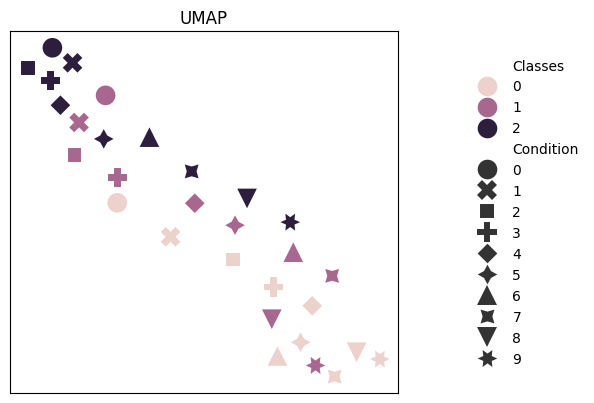

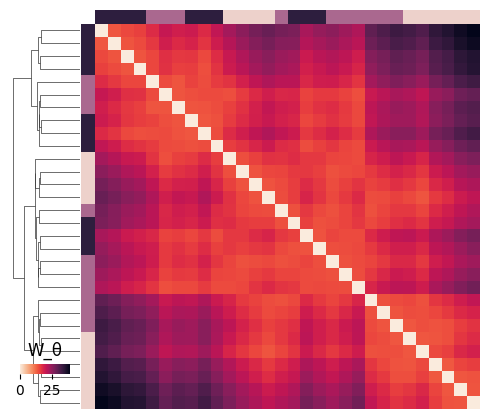

100%|██████████| 5/5 [06:16<00:00, 75.35s/it]


Iteration 0 with Loss  9542.1904296875
Average time for neigh 3 and Rank 5 is 376.7302830219269


100%|██████████| 5/5 [06:04<00:00, 72.99s/it]


Iteration 1 with Loss  1632.59716796875
Average time for neigh 3 and Rank 5 is 370.8332802057266


100%|██████████| 5/5 [05:52<00:00, 70.56s/it]


Iteration 2 with Loss  1012.8358764648438
Average time for neigh 3 and Rank 5 is 364.8249754110972


100%|██████████| 5/5 [06:04<00:00, 72.89s/it]


Iteration 3 with Loss  829.3006591796875
Average time for neigh 3 and Rank 5 is 364.72899305820465


100%|██████████| 5/5 [05:51<00:00, 70.34s/it]


Iteration 4 with Loss  705.1720581054688
Average time for neigh 3 and Rank 5 is 362.119802904129


100%|██████████| 5/5 [05:46<00:00, 69.31s/it]


Iteration 5 with Loss  622.2377319335938
Average time for neigh 3 and Rank 5 is 359.52854983011883


100%|██████████| 5/5 [05:40<00:00, 68.08s/it]


Iteration 6 with Loss  421.3395080566406
Average time for neigh 3 and Rank 5 is 356.79885074070523


100%|██████████| 5/5 [05:29<00:00, 65.99s/it]


Iteration 7 with Loss  527.1558227539062
Average time for neigh 3 and Rank 5 is 353.44575253129005


100%|██████████| 5/5 [05:57<00:00, 71.58s/it]


Iteration 8 with Loss  658.1118774414062
Average time for neigh 3 and Rank 5 is 353.9416360590193


100%|██████████| 5/5 [05:40<00:00, 68.19s/it]


Iteration 9 with Loss  646.2963256835938
Average time for neigh 3 and Rank 5 is 352.6434890270233


100%|██████████| 5/5 [09:59<00:00, 119.90s/it]


Iteration 10 with Loss  580.8941040039062
Average time for neigh 3 and Rank 5 is 375.08383414962077


100%|██████████| 5/5 [07:21<00:00, 88.26s/it] 


Iteration 11 with Loss  589.4537963867188
Average time for neigh 3 and Rank 5 is 380.60332109530765


100%|██████████| 5/5 [07:27<00:00, 89.43s/it] 


Iteration 12 with Loss  535.0281982421875
Average time for neigh 3 and Rank 5 is 385.72061922000006


100%|██████████| 5/5 [20:24<00:00, 244.84s/it]


Iteration 13 with Loss  426.15966796875
Average time for neigh 3 and Rank 5 is 445.61170819827487


100%|██████████| 5/5 [43:56<00:00, 527.34s/it]


Iteration 14 with Loss  320.82373046875
Average time for neigh 3 and Rank 5 is 591.6853517691294


100%|██████████| 5/5 [2:14:44<00:00, 1616.91s/it]  


Iteration 15 with Loss  547.94189453125
Average time for neigh 3 and Rank 5 is 1059.9881282448769


100%|██████████| 5/5 [50:35<00:00, 607.17s/it]   


Iteration 16 with Loss  549.794189453125
Average time for neigh 3 and Rank 5 is 1176.2161245766808


100%|██████████| 5/5 [17:37<00:00, 211.42s/it]


Iteration 17 with Loss  455.7376403808594
Average time for neigh 3 and Rank 5 is 1169.599679629008


100%|██████████| 5/5 [11:17<00:00, 135.45s/it]


Iteration 18 with Loss  492.7274169921875
Average time for neigh 3 and Rank 5 is 1143.687596032494


100%|██████████| 5/5 [29:38<00:00, 355.77s/it]


Iteration 19 with Loss  429.0479431152344
Average time for neigh 3 and Rank 5 is 1175.446339714527


100%|██████████| 5/5 [1:06:46<00:00, 801.34s/it] 


Iteration 20 with Loss  585.3787841796875
Average time for neigh 3 and Rank 5 is 1310.2681986150287


100%|██████████| 5/5 [07:51<00:00, 94.36s/it] 


Iteration 21 with Loss  554.8671264648438
Average time for neigh 3 and Rank 5 is 1272.155851060694


100%|██████████| 5/5 [08:09<00:00, 97.81s/it] 


Iteration 22 with Loss  482.5516052246094
Average time for neigh 3 and Rank 5 is 1238.1073968825133


100%|██████████| 5/5 [08:36<00:00, 103.26s/it]


Iteration 23 with Loss  491.4309387207031
Average time for neigh 3 and Rank 5 is 1208.0317074557145


100%|██████████| 5/5 [08:49<00:00, 105.99s/it]


Iteration 24 with Loss  551.1536865234375
Average time for neigh 3 and Rank 5 is 1180.9084090328217
Compute all OT distances after 24 iterations


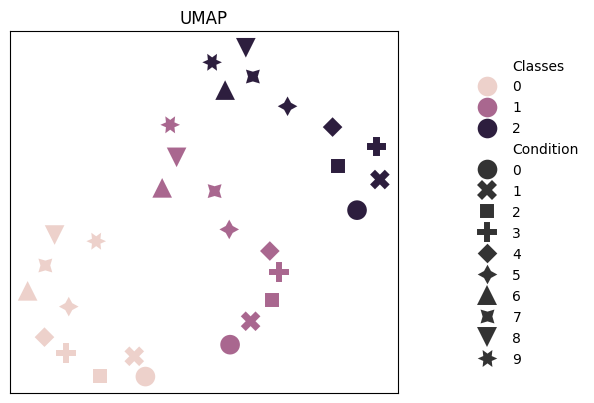

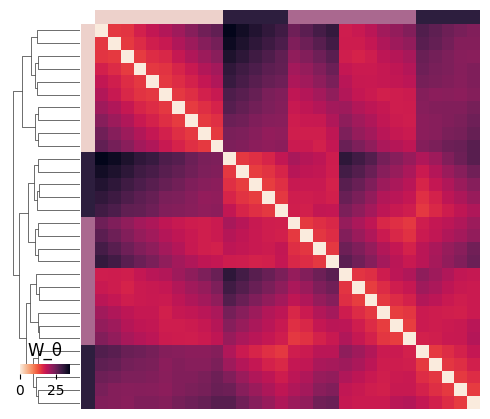

100%|██████████| 5/5 [07:35<00:00, 91.15s/it] 


Iteration 0 with Loss  7673.44091796875
Average time for neigh 3 and Rank 5 is 455.7629692554474


100%|██████████| 5/5 [08:18<00:00, 99.76s/it] 


Iteration 1 with Loss  925.7233276367188
Average time for neigh 3 and Rank 5 is 477.2828713655472


100%|██████████| 5/5 [08:39<00:00, 103.91s/it]


Iteration 2 with Loss  802.7296142578125
Average time for neigh 3 and Rank 5 is 491.3789155483246


100%|██████████| 5/5 [10:24<00:00, 124.99s/it]


Iteration 3 with Loss  697.8797607421875
Average time for neigh 3 and Rank 5 is 524.7720795869827


100%|██████████| 5/5 [09:28<00:00, 113.68s/it]


Iteration 4 with Loss  684.2469482421875
Average time for neigh 3 and Rank 5 is 533.5028461933136


100%|██████████| 5/5 [07:34<00:00, 90.85s/it] 


Iteration 5 with Loss  600.9411010742188
Average time for neigh 3 and Rank 5 is 520.296348452568


100%|██████████| 5/5 [08:15<00:00, 99.00s/it] 


Iteration 6 with Loss  618.5527954101562
Average time for neigh 3 and Rank 5 is 516.6853124414172


100%|██████████| 5/5 [09:10<00:00, 110.02s/it]


Iteration 7 with Loss  678.4754028320312
Average time for neigh 3 and Rank 5 is 520.8598847389221


100%|██████████| 5/5 [07:59<00:00, 95.90s/it] 


Iteration 8 with Loss  588.7298583984375
Average time for neigh 3 and Rank 5 is 516.2651326126522


100%|██████████| 5/5 [08:06<00:00, 97.33s/it] 


Iteration 9 with Loss  756.8250122070312
Average time for neigh 3 and Rank 5 is 513.3059965610504


100%|██████████| 5/5 [07:37<00:00, 91.41s/it] 


Iteration 10 with Loss  683.5385131835938
Average time for neigh 3 and Rank 5 is 508.19422032616353


100%|██████████| 5/5 [08:10<00:00, 98.02s/it] 


Iteration 11 with Loss  639.875
Average time for neigh 3 and Rank 5 is 506.687358935674


100%|██████████| 5/5 [08:38<00:00, 103.67s/it]


Iteration 12 with Loss  568.8436279296875
Average time for neigh 3 and Rank 5 is 507.58523669609656


100%|██████████| 5/5 [07:43<00:00, 92.67s/it] 


Iteration 13 with Loss  619.4243774414062
Average time for neigh 3 and Rank 5 is 504.4261767183031


100%|██████████| 5/5 [07:33<00:00, 90.73s/it] 


Iteration 14 with Loss  588.939697265625
Average time for neigh 3 and Rank 5 is 501.04241415659584


100%|██████████| 5/5 [07:15<00:00, 87.02s/it] 


Iteration 15 with Loss  641.8904418945312
Average time for neigh 3 and Rank 5 is 496.92044089734554


100%|██████████| 5/5 [07:15<00:00, 87.04s/it] 


Iteration 16 with Loss  407.9015197753906
Average time for neigh 3 and Rank 5 is 493.2902578325833


100%|██████████| 5/5 [07:10<00:00, 86.08s/it] 


Iteration 17 with Loss  522.2666015625
Average time for neigh 3 and Rank 5 is 489.7952647871441


100%|██████████| 5/5 [07:25<00:00, 89.03s/it] 


Iteration 18 with Loss  436.9747314453125
Average time for neigh 3 and Rank 5 is 487.44486921711973


100%|██████████| 5/5 [07:56<00:00, 95.23s/it] 


Iteration 19 with Loss  561.1281127929688
Average time for neigh 3 and Rank 5 is 486.88122979402544


100%|██████████| 5/5 [07:39<00:00, 91.84s/it] 


Iteration 20 with Loss  505.7742004394531
Average time for neigh 3 and Rank 5 is 485.56209326925733


100%|██████████| 5/5 [07:11<00:00, 86.24s/it] 


Iteration 21 with Loss  444.19500732421875
Average time for neigh 3 and Rank 5 is 483.0916268717159


100%|██████████| 5/5 [08:02<00:00, 96.55s/it] 


Iteration 22 with Loss  716.57763671875
Average time for neigh 3 and Rank 5 is 483.0772858287977


 20%|██        | 1/5 [02:02<08:08, 122.21s/it]

In [ ]:

for a,l,t,k in train_dataset.keys():
    if (a,l,t,k) in times.keys():
        continue

    alpha = torch.scalar_tensor(a)
    lambda_ = torch.scalar_tensor(l) 

    #Init Theta according to set rank k
    if k is None:
        k = dim

    if dia_only:
        if k is not None:
            raise Warning    
        w_rand =  torch.distributions.uniform.Uniform(-1,1).sample([dim])
        w_euc = torch.ones((dim))
    else:
        w_rand =  torch.distributions.uniform.Uniform(-1,1).sample([k,dim])   #torch.from_numpy(np.asarray(np.random.uniform(-1,1,(2,2)),dtype="f")) 
        w_euc = torch.diag(torch.ones((dim)))[:k,:] #TODO prob identity func in torch, yes and its .eye and not .identity!

    #TODO check if save to delete (aka how paranoid do i have to be with my tensors)
    w_rand.requires_grad_(requires_grad=True)
    w_rand.retain_grad()
    w_euc.requires_grad_(requires_grad=True) 
    w_euc.retain_grad()

    w_theta = w_rand.clone()
    w_theta.requires_grad_(requires_grad=True) 
    w_theta.retain_grad()

    #Init loss
    total_loss_random_theta = 0
    total_loss_best_theta = 0

    losses = []
    iteration_losses_total = []

    times[(a,l,t,k)] = []
    
    for i in range(iterations):
    #Iterations
        start_epoch = time.time()
        
        optimizer = torch.optim.Adam([w_theta], lr=lr)
        iteration_losses = []

        #print(type(train_dataset))
        #train_dataset_shuffled = random.sample([minibatch for minibatch in train_dataset],k=len(train_dataset))

        for triplets, labels in tqdm(train_dataset[(a,l,t,k)]):
        #Minibatches
            optimizer.zero_grad()
            loss = torch.scalar_tensor(0, requires_grad=True) #TODO doesnt actually require gradient
            for trip,labels in zip(triplets,labels):
            #Triplet

                trip.requires_grad_(requires_grad=True)
                loss = loss + triplet_loss(trip,w_theta,alpha)

                #gradient=w_rand
            #Regularization    
            loss = loss + lambda_ * torch.linalg.norm(w_theta,ord=1) / len(triplets) #TODO scale one by size of triplets as otherwise batchsize influences weighting of regularization
            #loss = loss + torch.linalg.norm(torch.matmul(w_theta.transpose(0,1),w_theta)-torch.eye(dim),ord=1) #penalize derivations from euclidean

            loss.backward()

            iteration_losses.append(loss.clone().detach().numpy()) #triplet_loss(t,w_rand)

            #total_loss_best_theta += triplet_loss(t,w_opt)
            optimizer.step()
            optimizer.zero_grad()
            #w_theta = w_theta - lr * w_theta.grad
            #print(f"Minibatch Loss  {np.average(iteration_losses)}")

            w_theta.grad = None
            w_theta.requires_grad_(requires_grad=True)
            w_theta.retain_grad()
        
        losses = np.concatenate((losses,iteration_losses))
        iteration_losses_total.append(np.sum(iteration_losses))
        print(f"Iteration {i} with Loss  {np.sum(iteration_losses)}")

        end_epoch = time.time() - start_epoch
        times[(a,l,t,k)].append(end_epoch)
        
        print(f"Average time for neigh {t} and Rank {k} is {np.average(times[(a,l,t,k)])}") #


        if i%plot_every_i_iterations==0 and i>0:
            print(f"Compute all OT distances after {i} iterations")
            D = training_data[(t)].compute_OT_on_dists(w = w_theta.clone().detach().numpy())    
        if i%save_every_i_iterations==0:
            thetas[(a,l,t,k)]=w_theta.clone().detach().numpy()
            np.save(f"/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/synth_200D/GGML/theta_{a}_{l}_{t}_{k}.npy",thetas[(a,l,t,k)])



In [11]:
table = np.zeros((len(rank_k),len(neighbor_t)))

for a,l,t,k in times.keys():
    #print(f"Average time for neigh {t} and Rank {k} is {np.average(times[(a,l,t,k)])}")
    table[rank_k.index(k),neighbor_t.index(t)] = np.average(times[(a,l,t,k)])

print(table)

from ggml.benchmark import knn_from_dists, plot_table, plot_1split
import pandas as pd

table_df = pd.DataFrame(data=table,index=rank_k,columns=neighbor_t).transpose()


display(table_df)
print(table_df.to_latex(index=True,
                #formatters={"name": str.upper},
                float_format="{:.1f}".format,
))

#7 & 646.02 & 671.54 & 740.73 \\

[[64.62701755]]


,5
3,64.627018


\begin{tabular}{lr}
\toprule
 & 5 \\
\midrule
3 & 64.6 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrrr}
\toprule
 & 5 & 10 & 50 & 100 & 200 \\
\midrule
1 & 12.9 & 14.5 & 15.8 & 17.0 & 22.3 \\
3 & 130.4 & 132.5 & 143.3 & 156.0 & 195.8 \\
5 & 348.6 & 361.3 & 365.2 & 417.3 & 525.4 \\
7 & NaN & 687.6 & 789.3 & 866.7 & 1040.5 \\
9 & 1049.1 & 1119.8 & 1249.2 & 1446.2 & 1703.2 \\
\bottomrule
\end{tabular}



[[-0.9018686     -0.8667987      0.8740431     -0.31665862
  -0.29825798    -0.017327456    0.39857355     0.55550355
   0.30400637    -0.1275783     -0.03281176     0.38252324
  -0.42768687    -0.020853166    0.6105658     -0.44294918
   0.558169      -0.8018289     -0.99710035    -0.070035815
   0.62519014    -0.13847369     0.4356124      0.5862382
   0.094938375    0.03941459    -0.3165639      0.34956792
  -0.38345543    -0.20512204    -0.4681703     -0.73885
  -0.67385346    -0.016790664    0.2186817      0.7817531
   0.34055936    -0.090277426   -1.0075164     -0.54191595
  -0.9503801      0.25465286     0.9335425     -0.41629818
   0.061096087    0.33574137    -0.9866865     -0.46806234
   0.20620053     0.85549325    -0.9679487      0.13933566
  -1.1077473      0.734167      -0.15793051    -0.34462655
   0.9343213     -0.32629842    -0.7049954      0.05990691
  -0.19360301    -0.43318462     0.9069301     -0.49952123
  -0.35453635     0.5730622     -0.5571592      0.686908
  -

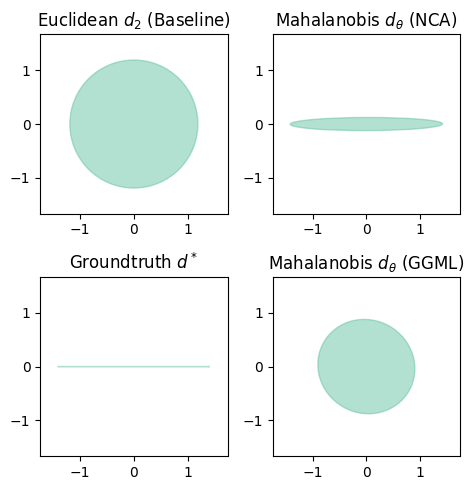

AttributeError: 'dict' object has no attribute 'compute_OT_on_dists'

<Figure size 240x240 with 0 Axes>

In [ ]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True,precision=16)
np.save("/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/synth_200D/GGML/w_theta.npy",w_theta.clone().detach().numpy())
print(w_theta.clone().detach().numpy())
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3,6))


#fig, ax = plt.subplots(figsize=(3,3))
ax = plot_w_theta(np.identity(2), ax=axs[0,0])
print(ax)
ax.set_title(r'Euclidean $d_2$ (Baseline)')
ax.get_figure().set_size_inches(4.8,5)

ax = plot_w_theta(w_theta.clone().detach().numpy(), ax=axs[1,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (GGML)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(M=np.asarray([[9.85031407, 0.02607956],
       [0.02607956, 0.07327278]]), ax=axs[0,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (NCA)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(np.asarray([[1,0],[0,0]]), ax=axs[1,0])
print(ax)
ax.set_title(r'Groundtruth $d^*$')
#ax.get_figure().set_size_inches(2.4,5)

plt.tight_layout()
plt.show()
from matplotlib.pyplot import figure

figure(figsize=(3, 3), dpi=80)

training_data.compute_OT_on_dists(w = w_theta.clone().detach().numpy(),legend=None)


[  0.                  2.16                4.32
   6.48                8.64               10.8
  12.96               15.120000000000001  17.28
  19.44               21.6                23.76
  25.92               28.080000000000002  30.240000000000002
  32.400000000000006  34.56               36.72
  38.88               41.040000000000006  43.2
  45.36               47.52               49.68000000000001
  51.84               54.                 56.160000000000004
  58.32000000000001   60.480000000000004  62.64
  64.80000000000001   66.96000000000001   69.12
  71.28               73.44               75.60000000000001
  77.76               79.92               82.08000000000001
  84.24000000000001   86.4                88.56
  90.72               92.88000000000001   95.04
  97.2                99.36000000000001  101.52000000000001
 103.68              105.84              108.
 110.16000000000001  112.32000000000001  114.48
 116.64000000000001  118.80000000000001  120.96000000000001
 123.1

ValueError: x and y must have same first dimension, but have shapes (100,) and (18,)

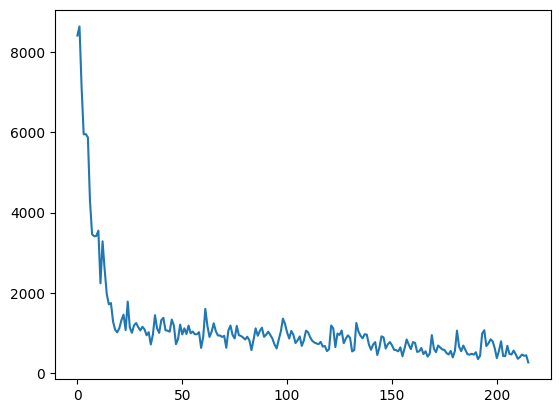

: 

: 

: 

In [ ]:
t = np.arange(len(losses))
datapoints_per_iteration = len(losses)/iterations
t2 = np.arange(0,len(losses),datapoints_per_iteration)
print(t2)
print(len(iteration_losses_total))
print(w_theta)
#fig, ax = plt.subplots()
plt.plot(t, losses, label = "loss minibatches")
plt.plot(t2, [l/datapoints_per_iteration for l in iteration_losses_total], label = "average loss iteration")
plt.legend() 




#print(total_loss_best_theta)


In [ ]:
for p1 in 

SyntaxError: invalid syntax (2993858587.py, line 1)

: 

: 

: 